# Load and Prepare News Data

This cell imports necessary libraries and loads news data using a custom data loader function. It prints the first few rows of the news DataFrame to inspect its structure, adds sentiment scores to the headlines, and aggregates the sentiment scores by date to compute the average daily sentiment.

In [2]:
from scripts.data_loader import load_and_prepare_news
from scripts.sentiment import add_sentiment_scores
import matplotlib.pyplot as plt
import pandas as pd

news_df = load_and_prepare_news()
print(news_df.head())
news_df = add_sentiment_scores(news_df)

# Aggregate by date
daily_sentiment = news_df.groupby('date')['sentiment'].mean().reset_index()
daily_sentiment.columns = ['Date', 'AvgSentiment']


   Unnamed: 0                                           headline  \
0           0            Stocks That Hit 52-Week Highs On Friday   
1           1         Stocks That Hit 52-Week Highs On Wednesday   
2           2                      71 Biggest Movers From Friday   
3           3       46 Stocks Moving In Friday's Mid-Day Session   
4           4  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
0  https://www.benzinga.com/news/20/06/16190091/s...  Benzinga Insights   
1  https://www.benzinga.com/news/20/06/16170189/s...  Benzinga Insights   
2  https://www.benzinga.com/news/20/05/16103463/7...         Lisa Levin   
3  https://www.benzinga.com/news/20/05/16095921/4...         Lisa Levin   
4  https://www.benzinga.com/news/20/05/16095304/b...         Vick Meyer   

         date stock  
0  2020-06-05     A  
1  2020-06-03     A  
2  2020-05-26     A  
3  2020-05-22     A  
4  2020-05-22     A  


# Load Stock Price Data and Calculate Returns

This cell imports functions to load stock price data and calculate returns. It loads historical stock price data for multiple tickers into a dictionary, extracts the closing prices into a single DataFrame, computes daily returns for each stock, and resets the index to prepare the data for merging with sentiment data.

In [5]:
from scripts.portfolio import calculate_returns
from scripts.data_loader import load_yfinance_data

# Load the stock price data into a dictionary
all_stocks = load_yfinance_data()


# Build a DataFrame of Close prices from all stocks
close_prices = pd.concat(
    [df['Close'].rename(ticker) for ticker, df in all_stocks.items()],
    axis=1
)

# Compute daily returns
daily_returns = calculate_returns(close_prices)

# Reset index to merge with sentiment
daily_returns = daily_returns.reset_index().rename(columns={'index': 'Date'})


# Merge Sentiment and Returns Data

This cell ensures that the 'Date' columns in both the sentiment and returns DataFrames are in datetime format for consistent merging. It merges the daily sentiment and returns data on the 'Date' column using an inner join, and displays the first few rows of the merged DataFrame to verify the result.

In [7]:
# Ensure both Date columns are in the same format
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])
daily_returns['Date'] = pd.to_datetime(daily_returns['Date'])


# Merge sentiment and returns
merged = pd.merge(daily_sentiment, daily_returns, on='Date', how='inner')
merged.head()


,Date,AvgSentiment,TSLA,AMZN,META,GOOG,NVDA,AAPL,MSFT
0,2012-12-13,0.008333,-0.046795,-0.002026,0.023930,0.007369,0.000799,-0.017273,-0.004772
1,2012-12-14,-0.070000,0.005950,-0.008199,-0.050637,-0.001053,0.004788,-0.037569,-0.011066
2,2012-12-17,0.000000,0.017450,0.018741,-0.002238,0.026811,-0.003971,0.017733,0.010817
3,2012-12-18,0.000000,0.005523,0.025762,0.035888,0.000402,0.001595,0.029046,0.016974
4,2012-12-19,0.226190,0.000578,-0.009255,-0.010826,-0.001331,0.007166,-0.014216,-0.009071


# Calculate Correlation Between Sentiment and Returns

This cell computes the correlation between average daily sentiment and daily stock returns for each ticker in the merged DataFrame. It stores the results in a dictionary, converts it to a DataFrame, and sorts the correlations in descending order for visualization or further analysis.

In [8]:
correlation_results = {}

for ticker in daily_returns.columns[1:]:  # skip Date
    if ticker in merged.columns:
        correlation = merged['AvgSentiment'].corr(merged[ticker])
        correlation_results[ticker] = correlation

# Create a DataFrame for visualization
correlation_df = pd.DataFrame.from_dict(correlation_results, orient='index', columns=['Correlation'])
correlation_df = correlation_df.sort_values(by='Correlation', ascending=False)


# Visualize Average Sentiment by Headline Topic

This cell groups the news data by topic, calculates the average sentiment for each topic, and creates a horizontal bar plot to visualize the results. The plot is titled "Average Sentiment by Headline Topic" and uses a cornflowerblue color for the bars.

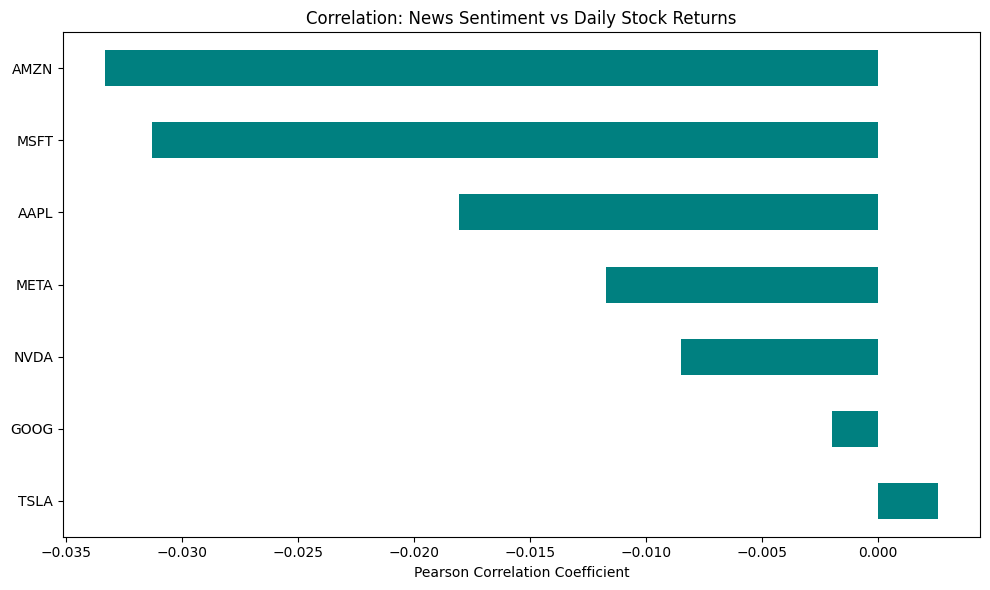

In [10]:
correlation_df.plot(kind='barh', figsize=(10, 6), title='Correlation: News Sentiment vs Daily Stock Returns', legend=False, color='teal')
plt.xlabel("Pearson Correlation Coefficient")
plt.tight_layout()
plt.show()


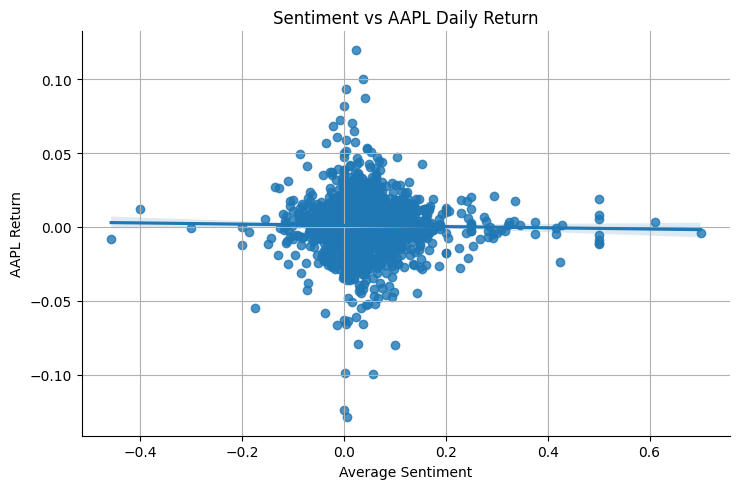

In [11]:
import seaborn as sns

sns.lmplot(x='AvgSentiment', y='AAPL', data=merged, height=5, aspect=1.5)
plt.title('Sentiment vs AAPL Daily Return')
plt.xlabel('Average Sentiment')
plt.ylabel('AAPL Return')
plt.grid(True)
plt.tight_layout()
plt.show()


In [12]:
from scripts.topic_analysis import tag_headline

news_df['topic'] = news_df['headline'].apply(tag_headline)


<Axes: title={'center': 'Average Sentiment by Headline Topic'}, ylabel='topic'>

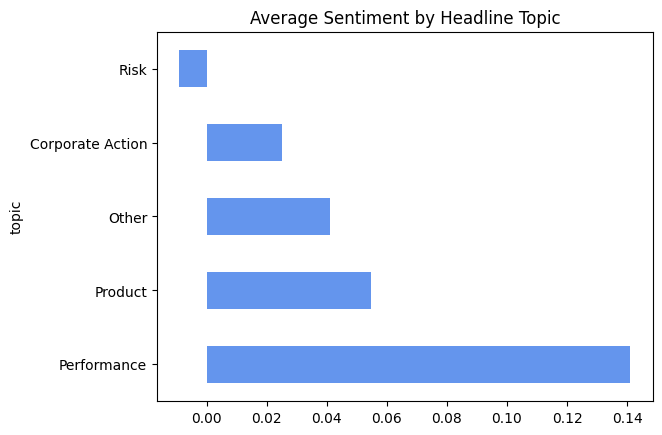

In [14]:
topic_sentiment = news_df.groupby('topic')['sentiment'].mean().sort_values(ascending=False)
topic_sentiment.plot(kind='barh', title="Average Sentiment by Headline Topic", color="cornflowerblue")


In [15]:
# Group by date and topic
daily_topic_sentiment = (
    news_df.groupby(['date', 'topic'])['sentiment']
    .mean()
    .reset_index()
    .rename(columns={'date': 'Date', 'sentiment': 'AvgSentiment'})
)


In [16]:
correlation_by_topic = {}

# Ensure daily_returns['Date'] is datetime64
daily_returns['Date'] = pd.to_datetime(daily_returns['Date'])

# Loop over each unique topic
for topic in daily_topic_sentiment['topic'].unique():
    topic_df = daily_topic_sentiment[daily_topic_sentiment['topic'] == topic]

    # Merge topic sentiment with daily returns
    merged = pd.merge(topic_df, daily_returns, on='Date', how='inner')

    # Compute correlation with each stock
    correlations = {
        ticker: merged['AvgSentiment'].corr(merged[ticker])
        for ticker in daily_returns.columns if ticker != 'Date'
    }

    correlation_by_topic[topic] = correlations


ValueError: You are trying to merge on object and datetime64[ns] columns for key 'Date'. If you wish to proceed you should use pd.concat